K-Means clustering uses vector quantization, which partitions **n** observations into **k** clusters in which each observation belongs in a cluster with the nearest centroid (mean)


In [325]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os, json, math, warnings, joblib, textwrap
from dataclasses import dataclass
from typing import List, Dict, Tuple

warnings.filterwarnings("ignore")   

random_state = 42
np.random.seed(random_state)

In [326]:
dataset="playerstats.csv"
df = pd.read_csv(dataset)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2257 entries, 0 to 2256
Data columns (total 36 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Player                   2257 non-null   object 
 1   Nation                   2256 non-null   object 
 2   Squad                    2257 non-null   object 
 3   Age                      2256 non-null   float64
 4   Born                     2257 non-null   int64  
 5   Playing Time MP          2257 non-null   int64  
 6   Playing Time Starts      2257 non-null   int64  
 7   Playing Time Min         2257 non-null   int64  
 8   Playing Time 90s         2257 non-null   float64
 9   Performance Gls          2257 non-null   int64  
 10  Performance Ast          2257 non-null   int64  
 11  Performance G+A          2257 non-null   int64  
 12  Performance G-PK         2257 non-null   int64  
 13  Performance PK           2257 non-null   int64  
 14  Performance PKatt       

In [327]:
df.dtypes

Player                      object
Nation                      object
Squad                       object
Age                        float64
Born                         int64
Playing Time MP              int64
Playing Time Starts          int64
Playing Time Min             int64
Playing Time 90s           float64
Performance Gls              int64
Performance Ast              int64
Performance G+A              int64
Performance G-PK             int64
Performance PK               int64
Performance PKatt            int64
Performance CrdY             int64
Performance CrdR             int64
Expected xG                float64
Expected npxG              float64
Expected xAG               float64
Expected npxG+xAG          float64
Progression PrgC             int64
Progression PrgP             int64
Progression PrgR             int64
Per 90 Minutes Gls         float64
Per 90 Minutes Ast         float64
Per 90 Minutes G+A         float64
Per 90 Minutes G-PK        float64
Per 90 Minutes G+A-P

In [328]:
df.head()

,Player,Nation,Squad,Age,Born,Playing Time MP,Playing Time Starts,Playing Time Min,Playing Time 90s,Performance Gls,...,Per 90 Minutes G+A,Per 90 Minutes G-PK,Per 90 Minutes G+A-PK,Per 90 Minutes xG,Per 90 Minutes xAG,Per 90 Minutes xG+xAG,Per 90 Minutes npxG,Per 90 Minutes npxG+xAG,Position,League
0,Brenden Aaronson,USA,Leeds United,25.0,2000,10,7,638,7.1,1,...,0.14,0.14,0.14,0.23,0.18,0.41,0.23,0.41,"FW,MF",Premier League
1,Jones El-Abdellaoui,MAR,Celta Vigo,19.0,2006,3,0,85,0.9,0,...,0.00,0.00,0.00,0.56,0.05,0.61,0.56,0.61,"MF,FW",La Liga
2,Himad Abdelli,ALG,Angers,25.0,1999,7,5,438,4.9,1,...,0.21,0.00,0.00,0.22,0.06,0.28,0.06,0.12,MF,Ligue 1
3,Ali Abdi,TUN,Nice,31.0,1993,4,4,255,2.8,0,...,0.00,0.00,0.00,0.00,0.14,0.14,0.00,0.14,"DF,MF",Ligue 1
4,Salis Abdul Samed,GHA,Nice,25.0,2000,8,5,352,3.9,0,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,MF,Ligue 1


In [329]:
# Configurations for player positions

goalkeepers = ['Goalkeeper']
defenders = ['Defender']
midfielders = ['Midfielder']
forwards = ['Forward']
df['Position'].unique()

array(['FW,MF', 'MF,FW', 'MF', 'DF,MF', 'DF', 'FW,DF', 'FW', 'GK',
       'DF,FW', 'MF,DF'], dtype=object)

In [330]:
df.fillna(0, inplace=True)
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f'Number of categorical columns: {len(cat_cols)}')
print(f'Number of numerical columns: {len(num_cols)}')

Number of categorical columns: 5
Number of numerical columns: 31


In [331]:
# Defining Statistical Groups

profile = [
    "Player", "Nation", "League", "Squad",
    "Position",
    "Age", "Born",
    "Playing Time MP", "Playing Time Starts",
    "Playing Time Min", "Playing Time 90s"
]

passing_metrics = [
    "Performance Ast", "Expected xAG", "Expected npxG+xAG",
    "Per 90 Minutes Ast", "Per 90 Minutes xAG",
    "Per 90 Minutes xG+xAG", "Progression PrgP",
    "Progression PrgC"
]

creation_metrics = [
    "Per 90 Minutes G+A", "Per 90 Minutes G+A-PK",
    "Performance G+A", "Expected npxG+xAG",
    "Per 90 Minutes npxG+xAG", "Progression PrgR"
]

shooting_metrics = [
    "Performance Gls", "Performance G-PK",
    "Performance PK", "Performance PKatt",
    "Expected xG", "Expected npxG",
    "Per 90 Minutes Gls", "Per 90 Minutes G-PK",
    "Per 90 Minutes npxG", "Per 90 Minutes xG",
    "Per 90 Minutes npxG+xAG"
]

cards = [
    "Performance CrdY",  # Yellow cards
    "Performance CrdR"   # Red cards
]

Feature Dictionary
| **Feature** | **Definition** |
|--------------|------------------------------|
| Player | Name of the player. |
| Nation | Country or nationality of the player. |
| League | League in which the player competes. |
| Squad | Club or team name. |
| Position | Position of player  (e.g., FW, MF, DF, GK). |
| Age | Age of the player (in years). |
| Born | Year or date of birth. |
| Playing Time MP | Matches played (appearances). |
| Playing Time Starts | Number of matches started. |
| Playing Time Min | Total minutes played. |
| Playing Time 90s | Matches played expressed in 90-minute equivalents (Minutes ÷ 90). |
| Performance Ast | Total assists provided. |
| Expected xAG | Expected assists — measures the likelihood that passes become goals. |
| Expected npxG+xAG | Combined non-penalty expected goals and expected assists. |
| Per 90 Minutes Ast | Assists per 90 minutes played. |
| Per 90 Minutes xAG | Expected assists per 90 minutes. |
| Per 90 Minutes xG+xAG | Expected goals + expected assists per 90 minutes. |
| Progression PrgP | Progressive passes — forward passes moving the ball significantly toward goal. |
| Progression PrgC | Progressive carries — distance the player carries the ball forward. |
| Per 90 Minutes G+A | Combined goals and assists per 90 minutes. |
| Per 90 Minutes G+A-PK | Goals and assists per 90 minutes excluding penalties. |
| Performance G+A | Total goals plus assists. |
| Expected npxG+xAG | Expected goals (non-penalty) plus expected assists — indicator of involvement in chance creation. |
| Per 90 Minutes npxG+xAG | Expected non-penalty goals + assists per 90 minutes. |
| Progression PrgR | Progressive receptions — how often a player receives the ball in advanced positions. |
| Performance Gls | Total goals scored. |
| Performance G-PK | Non-penalty goals. |
| Performance PK | Penalty goals scored. |
| Performance PKatt | Penalty attempts taken. |
| Expected xG | Expected goals — probability of converting shots based on shot quality. |
| Expected npxG | Non-penalty expected goals. |
| Per 90 Minutes Gls | Goals scored per 90 minutes. |
| Per 90 Minutes G-PK | Non-penalty goals per 90 minutes. |
| Per 90 Minutes npxG | Non-penalty expected goals per 90 minutes. |
| Per 90 Minutes xG | Expected goals per 90 minutes. |
| Per 90 Minutes npxG+xAG | Combined expected non-penalty goals and assists per 90 minutes. |
| Performance CrdY | Yellow cards received. |
| Performance CrdR | Red cards received. |



In [332]:
df['Position'].unique()

array(['FW,MF', 'MF,FW', 'MF', 'DF,MF', 'DF', 'FW,DF', 'FW', 'GK',
       'DF,FW', 'MF,DF'], dtype=object)

In [ ]:
position = ['MF ']
df = df[df['Position'].isin(position)]

In [334]:
df = df[df['Playing Time 90s'] >= 5]

In [335]:
df['League'].unique()

array(['Ligue 1', 'Premier League', 'Serie A', 'La Liga', 'Bundesliga'],
      dtype=object)

In [336]:
league = 'Premier League' 
df_comp = df[df['League'] == league]

df_eng = df_comp[['Player']+passing_metrics+creation_metrics+shooting_metrics]
df_eng.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, 18 to 2254
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Player                   45 non-null     object 
 1   Performance Ast          45 non-null     int64  
 2   Expected xAG             45 non-null     float64
 3   Expected npxG+xAG        45 non-null     float64
 4   Per 90 Minutes Ast       45 non-null     float64
 5   Per 90 Minutes xAG       45 non-null     float64
 6   Per 90 Minutes xG+xAG    45 non-null     float64
 7   Progression PrgP         45 non-null     int64  
 8   Progression PrgC         45 non-null     int64  
 9   Per 90 Minutes G+A       45 non-null     float64
 10  Per 90 Minutes G+A-PK    45 non-null     float64
 11  Performance G+A          45 non-null     int64  
 12  Expected npxG+xAG        45 non-null     float64
 13  Per 90 Minutes npxG+xAG  45 non-null     float64
 14  Progression PrgR         45 no

In [337]:
df_3d = df_eng.copy()

In [338]:
from sklearn.preprocessing import StandardScaler

In [339]:
player_names = df_eng['Player'].tolist()
df_eng.drop(columns=['Player'], inplace=True)

x = df_eng.values
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_norm = pd.DataFrame(x_scaled, columns=df_eng.columns)

In [340]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
reduced = pd.DataFrame(pca.fit_transform(x_norm))
reduced.head()

,0,1
0,-4.084210,0.349630
1,-3.908128,-0.754243
2,0.023018,-2.687760
3,-4.968467,-0.279782
4,-1.244345,0.157622


Text(0, 0.5, 'WCSS')

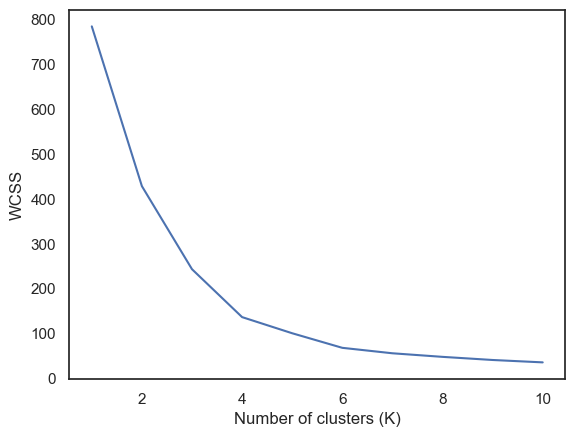

In [341]:
from sklearn.cluster import KMeans

wcss = [] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(reduced) 
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')


In [342]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6)
kmeans = kmeans.fit(reduced)

labels = kmeans.predict(reduced)
clusters = kmeans.labels_.tolist()

In [343]:
reduced['cluster'] = clusters
reduced['name'] = player_names
reduced.columns = ['x', 'y', 'cluster', 'name']
reduced.head()

,x,y,cluster,name
0,-4.084210,0.349630,5,Tyler Adams
1,-3.908128,-0.754243,5,Ethan Ampadu
2,0.023018,-2.687760,4,Elliot Anderson
3,-4.968467,-0.279782,5,André
4,-1.244345,0.157622,0,Yasin Ayari


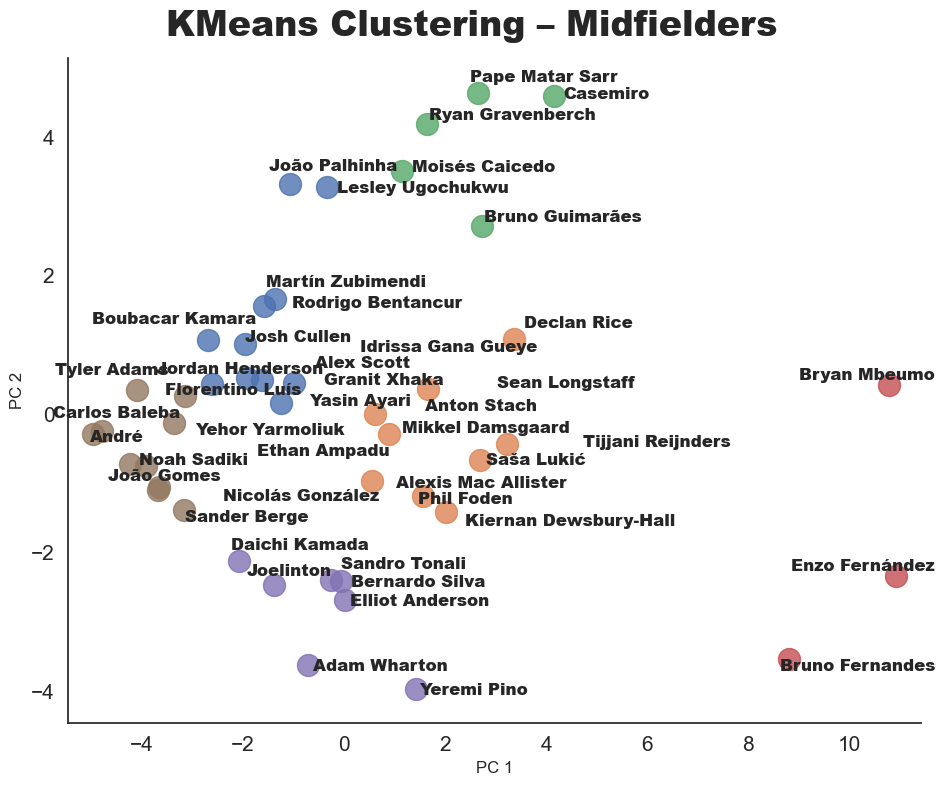

In [344]:
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text  # Optional: prevents label overlap

# Ensure inline plotting for notebooks
%matplotlib inline

# Set Seaborn style
sns.set_theme(style="white")

# Create FacetGrid with scatter plot
g = sns.lmplot(
    x="x", y="y", hue='cluster', data=reduced,
    legend=False, fit_reg=False,
    scatter_kws={"s": 250}, height=8, aspect=1.2
)

# Access the actual Axes object
ax = g.ax

# Add text labels to each point
texts = [ax.text(x, y, s, fontweight='heavy') for x, y, s in zip(reduced.x, reduced.y, reduced.name)]

# Optional: prevent label overlap
adjust_text(texts, ax=ax)

# Expand axis limits to fit labels
x_min, x_max = reduced.x.min(), reduced.x.max()
y_min, y_max = reduced.y.min(), reduced.y.max()
ax.set_xlim(x_min - 0.5, x_max + 0.5)
ax.set_ylim(y_min - 0.5, y_max + 0.5)

# Axis labels and title
g.set_axis_labels("PC 1", "PC 2")
g.fig.suptitle('KMeans Clustering – Midfielders', size=25, weight='heavy')

# Tidy layout and tick formatting
plt.tick_params(labelsize=15)
plt.tight_layout()
plt.subplots_adjust(top=0.92)  # Adjust for title spacing

In [345]:
# Print out Players in each cluster

for cluster_num in range(kmeans.n_clusters):
    cluster_players = reduced[reduced['cluster'] == cluster_num]['name'].tolist()
    print(f"Cluster {cluster_num}:")
    for player in cluster_players:
        print(f" - {player}")
    print("\n")



Cluster 0:
 - Yasin Ayari
 - Rodrigo Bentancur
 - Josh Cullen
 - Idrissa Gana Gueye
 - Jordan Henderson
 - Boubacar Kamara
 - João Palhinha
 - Alex Scott
 - Lesley Ugochukwu
 - Granit Xhaka
 - Martín Zubimendi


Cluster 1:
 - Mikkel Damsgaard
 - Kiernan Dewsbury-Hall
 - Phil Foden
 - Sean Longstaff
 - Saša Lukić
 - Alexis Mac Allister
 - Tijjani Reijnders
 - Declan Rice
 - Anton Stach


Cluster 2:
 - Moisés Caicedo
 - Casemiro
 - Ryan Gravenberch
 - Bruno Guimarães
 - Pape Matar Sarr


Cluster 3:
 - Bruno Fernandes
 - Enzo Fernández
 - Bryan Mbeumo


Cluster 4:
 - Elliot Anderson
 - Joelinton
 - Daichi Kamada
 - Yeremi Pino
 - Bernardo Silva
 - Sandro Tonali
 - Adam Wharton


Cluster 5:
 - Tyler Adams
 - Ethan Ampadu
 - André
 - Carlos Baleba
 - Sander Berge
 - João Gomes
 - Nicolás González
 - Florentino Luís
 - Noah Sadiki
 - Yehor Yarmoliuk


